<a href="https://colab.research.google.com/github/pepedp/COVID-19/blob/master/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 ![texto alternativo](https://www.acshoco.org/wp-content/uploads/2020/03/COVID-19.png)

**FUENTE DATOS:** `bigquery-public-data.covid19_jhu_csse.summary`  

# **Inicio**


In [1]:
#@title INICIO
#LIBRERIRAS 
import pandas as pd
import math
import numpy as np
import math
import matplotlib.pyplot as plt
from google.cloud import bigquery
import scipy.integrate 
%matplotlib inline 
 
#CONEXION BIGQUERY
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
 
#FUNCION PARA DETERMINAR LOS DIAS A PRONOSTICAR  
def dias_predecir(dias):
  from datetime import datetime 
  diferencia=datetime.today()-datetime.strptime(fecha_fin, '%Y-%m-%d')
  diferencia.days
  i=0
  semana=[]
  dia=0
  if (Exponencial):
    dia = dataset.index.get_loc(dataset.last_valid_index()-diferencia.days+1)
    for i in range(0,dias+diferencia.days):
      semana.append(dia+i)    
      i+=i
  else:
    dia = dataset.index.get_loc(dataset.last_valid_index() )
    for i in range(0,dias):
      semana.append(dia+i)    
      i+=i
  return semana
 
#FUNCION VELOCIDAD, ACELERACION E INDICE DE CRECIMIENTO
def vel_crecimiento(horas=24):
  j=0
  velocidad=[]
  aceleracion=[]
  indice_crecimiento=[]
  indice_activos=[]
  fin = dataset.index.get_loc(dataset.last_valid_index())
  if horas>24:
    print("Solicitud no procesada / NO debe ser mayor a 24 Horas")
  else:
    for j in range (0,fin+1):
      if j==0:
        velocidad.append(dataset.iloc[j:j+1, 2].values/(24/horas))
        aceleracion.append((velocidad[j]) )
        indice_crecimiento.append(dataset.iloc[j:j+1, 2].values)
        indice_activos.append(dataset.iloc[j:j+1, 5].values)
        j+=j
      else:    
        velocidad.append((dataset.iloc[j:j+1, 2].values - dataset.iloc[j-1:j, 2].values)/(24/horas))         
        aceleracion.append((velocidad[j]-velocidad[j-1]) )
        indice_crecimiento.append((dataset.iloc[j:j+1, 2].values/dataset.iloc[j-1:j, 2].values)) 
        indice_activos.append((dataset.iloc[j:j+1, 5].values/dataset.iloc[j-1:j, 5].values)) 
        j+=j
    return np.array(velocidad),np.array(aceleracion),np.array(indice_crecimiento), np.array(indice_activos)
 
 
#MODELO EXPONENCIAL
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#https://www.it-swarm.dev/es/python/como-hacer-el-ajuste-de-curvas-exponenciales-y-logaritmicas-en-python-solo-encontre-el-ajuste-polinomial/969066654/
 
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
 
def func_exp(x, a, b, c):
    funcion = a * np.exp(b * x) + c
    return funcion
 
def exponential_regression (x_data, y_data,dias,cond_aceleracion=False,country="Guatemala"):
    x_data=x_data.flatten()
    popt, pcov = curve_fit(func_exp, x_data, y_data, p0 = (-10, .2, 10))
    
    #PREDICCION
    x_exp = dias_predecir(dias)
    y_exp = []
    for i in range(0,len(x_exp)): 
      y_exp.append(func_exp(x_exp[i],popt[0],popt[1],popt[2]))
      i+=i
    
    #GRAFICA    
    plt.figure(figsize=[10,6])
    plt.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
    plt.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
    plt.title(pais+" - COVID-19")
    plt.xlabel('Dias desde primer caso (t)')
    plt.ylabel('Contagios')
    coef_a,coef_b,coef_c,decimales=popt[0],popt[1],popt[2],3
    tex_model="Activos" if (Activos) else "Contagios"
    texto = plt.text(5, np.max(y_exp)/2, r'$%s=%s\cdot e^{%st}% s$'%(tex_model,round(coef_a,decimales),round(coef_b,decimales),round(coef_c,decimales)), fontsize=16)
    plt.plot(x_data, func_exp(x_data, *popt), color='orange', label = "Modelo: {:.3f}*e({:.3f}*t){:.3f}".format(*popt))
    plt.plot(x_exp, y_exp, color='Green', label = "Tendencia")
    plt.grid()
    plt.legend()
    plt.show()
    salida = pd.DataFrame(np.round(func_exp(x_data, *popt),decimals=0),y_train) 
    #print("Indice de crecimiento del modelo: "+str(np.array(y_exp[1:2]).flatten()/np.array(y_exp[:1]).flatten()) )
    #print(*popt)
    print(np.round(y_exp[-dias_pred-1:],decimals=0))    
    return np.round(func_exp(x_data, *popt)), np.round(y_exp,decimals=0), popt
 
 
#ECUACIONES DIFERENCIALES
def Modelo_SIR(y,t, N,beta, gamma):            
    S, I, R = y
    
    dS = -beta*S*I/N
    dI = beta*S*I/N - gamma*I 
    dR = gamma*I 
    return ([dS, dI, dR])
 
def Modelo_SEIR(y,t,N,beta, gamma,epsilon,mu,B):
  S, E, I, R = y
  dS = -beta*S*I/N
  dE = beta*S*I/N - epsilon*E
  dI = epsilon*E - gamma*I 
  dR = gamma*I 
  return ([dS, dE, dI, dR])

# **Informe**

In [44]:
#@title
#@title PROCESAR DATOS
pais = "Mexico" #@param {type:"string"}
PorEstado = False #@param {type:"boolean"}
 
 
if (PorEstado):
  #CARGA DATASET
  project_id = "studied-temple-271217"
  sql = "SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary` where province_state in ('" + pais + "') order by date asc"
  dataset_origen = pd.read_gbq(sql, project_id=project_id, dialect='standard')
  
  #DATA CLEANNING  
  dataset = dataset_origen
  dataset = dataset.drop(["latitude","longitude"], axis = 1)
  dataset=dataset.groupby(["date","province_state"], as_index=False).sum()
  #dataset["active"] = dataset["confirmed"]-dataset["deaths"]-dataset["recovered"]
  dataset = dataset.fillna(0)
  #dataset["no_dias"]=dataset.index
  x,y,activos,muertes,recuperados = dataset.index.values.reshape(-1,1),dataset.iloc[:, 2].values,dataset.iloc[:, 5].values,dataset.iloc[:, 3].values,dataset.iloc[:, 4].values
  print(dataset["date"].head(1))
  print(dataset["date"].tail(1))
  #INICIALIZACION DE MODELOS 
  y_modelo,y_pred_test,prediccion_semana,indices_dias=[],[],[],8
 
else:
  #CARGA DATASET
  project_id = "studied-temple-271217"
  sql = "SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary` where country_region in ('" + pais + "') order by date asc"
  dataset_origen = pd.read_gbq(sql, project_id=project_id, dialect='standard')
  
  #DATA CLEANNING  
  dataset = dataset_origen
  dataset = dataset.drop(["latitude","longitude"], axis = 1)
  dataset=dataset.groupby(["date","country_region"], as_index=False).sum()
  dataset["active"] = dataset["confirmed"]-dataset["deaths"]-dataset["recovered"]
  dataset = dataset.fillna(0)
  #dataset["no_dias"]=dataset.index
  if pais == "Guatemala":
    dataset.update(pd.DataFrame({"confirmed":[70,74,80,87,126,137,153,316,342,557,585,1912,2001]}, index=[22,23,24,25,26,27,28,38,39,45,46,64,65])) 
    dataset.update(pd.DataFrame({"active":[477,1737,1822]}, index=[45,64,65])) 
  x,y,activos,muertes,recuperados = dataset.index.values.reshape(-1,1),dataset.iloc[:, 2].values,dataset.iloc[:, 5].values,dataset.iloc[:, 3].values,dataset.iloc[:, 4].values
  print(dataset["date"].head(1))
  print(dataset["date"].tail(1))
  #INICIALIZACION DE MODELOS 
  y_modelo,y_pred_test,prediccion_semana,indices_dias=[],[],[],8

0   2020-01-23
Name: date, dtype: datetime64[ns]
116   2020-06-22
Name: date, dtype: datetime64[ns]


- DÍAS DESDE EL PRIMER CONTAGIO:[116] 
- CONTAGIOS PROMEDIO POR HORA(Últimos 15 días): 189
- CRECIMIENTO DIARIO: Actual[4,577] || Máximo[5,662] 
- CONTAGIOS: Actual[185,122] || Pronostico_Hoy[190,723] || Indice_Crecimiento_Diario[1.0254] 
- ACTIVOS: Actual[23,155] || Pronostico_Hoy[23,434] || Indice_Crecimiento_Diario[0.9558] 
- RECUPERADOS:139,383 || [75.29%] 
- FALLECIDOS: 22,584 || [12.20%]

OBSERVACIONES:
- El crecimiento diario actual a bajado un 19.16% respecto al crecimiento diario mas alto
- Para bajar la curva de CONTAGIOS el INDICE CRECIMIENTO DIARIO debe ser muy cercano a 1 || PROMEDIO ÚLTIMOS 15 DÍAS[1.031]
- Para descender la curva de ACTIVOS el INDICE CRECIMIENTO DIARIO debe ser menor a 1 || PROMEDIO ÚLTIMOS 15 DÍAS[0.9382]
- Una Aceleración negativa indica baja en el crecimiento de contagios diarios || ACELERACIÓN ÚLTIMOS 15 DÍAS[1,093]


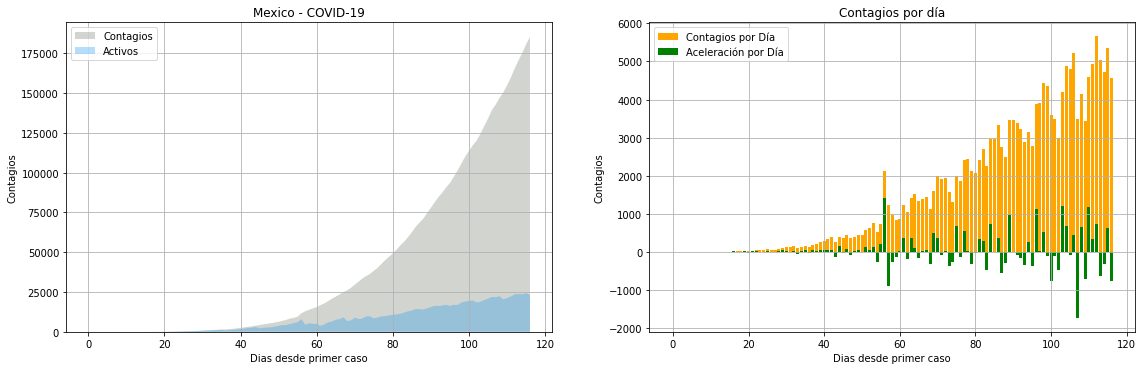

In [47]:
#@titleESTADO ACTUAL
VCH = False #Calculo por hora
Dias_Comparar = 15#@param {type:"integer"}
 
import warnings
warnings.filterwarnings("ignore")
fig,(axs,axs2) = plt.subplots(1,2)
plt.subplots_adjust(top=1.2, wspace=.2,right=2.6)
 
#GRAFICA CONTAGIOS & ACTIVOS
axs.set_title("{} - COVID-19".format(pais))
axs.set_ylabel('Contagios')
axs.set_xlabel('Dias desde primer caso')
axs.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
axs.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
axs.legend(loc='upper left')
axs.grid()
 
#GRAFICA CONTAGIOS POR DIA
horas= 1 if (VCH) else 24
texto_vel = "hora" if (VCH) else "día"
velocidad,aceleracion,indice_crecimiento,indice_activos=vel_crecimiento(horas)
axs2.set_title("Contagios por {}".format(texto_vel) )
axs2.set_xlabel('Dias desde primer caso')
axs2.set_ylabel('Contagios')
axs2.bar(x.flatten(),velocidad.flatten(),label="Contagios por Día",color="Orange" )
axs2.bar(x.flatten(),aceleracion.flatten(),label="Aceleración por Día",color="Green" )
axs2.legend(loc='upper left')
axs2.grid()
fig.show()
 
#METRICAS
print("""- DÍAS DESDE EL PRIMER CONTAGIO:{} 
- CONTAGIOS PROMEDIO POR HORA(Últimos {} días): {:,.0f}
- CRECIMIENTO DIARIO: Actual[{:,.0f}] || Máximo[{:,.0f}] 
- CONTAGIOS: Actual[{:,.0f}] || Pronostico_Hoy[{:,.0f}] || Indice_Crecimiento_Diario{} 
- ACTIVOS: Actual[{:,.0f}] || Pronostico_Hoy[{:,.0f}] || Indice_Crecimiento_Diario{} 
- RECUPERADOS:{:,.0f} || [{:,.2f}%] 
- FALLECIDOS: {:,.0f} || [{:,.2f}%]""".format(
    x[-1:].flatten(),
    Dias_Comparar,np.mean(velocidad[-Dias_Comparar:]/24),
    velocidad.flatten()[-1],np.max(velocidad),
    y[-1],y[-1]*np.mean(indice_crecimiento[-7:]),np.round(indice_crecimiento[-1:].flatten(),decimals=4),
    activos[-1],activos[-1]*np.mean(indice_activos[-Dias_Comparar:]),np.round(indice_activos[-1].flatten(),decimals=4),
    recuperados[-1],recuperados[-1]/y[-1]*100,
    muertes[-1],muertes[-1]/y[-1]*100) )
 
print("""\nOBSERVACIONES:
- El crecimiento diario actual a bajado un {:,.2f}% respecto al crecimiento diario mas alto
- Para bajar la curva de CONTAGIOS el INDICE CRECIMIENTO DIARIO debe ser muy cercano a 1 || PROMEDIO ÚLTIMOS {} DÍAS{}
- Para descender la curva de ACTIVOS el INDICE CRECIMIENTO DIARIO debe ser menor a 1 || PROMEDIO ÚLTIMOS {} DÍAS{}
- Una Aceleración negativa indica baja en el crecimiento de contagios diarios || ACELERACIÓN ÚLTIMOS {} DÍAS[{:,.0f}]""".format(
    (1-velocidad.flatten()[-1]/np.max(velocidad))*100,
    Dias_Comparar,np.round(np.mean(indice_crecimiento[-Dias_Comparar:]).flatten(),decimals=4),
    Dias_Comparar,np.round(np.mean(indice_activos[-Dias_Comparar]).flatten(),decimals=4),
    Dias_Comparar,np.sum(aceleracion[-Dias_Comparar:]) ))

# **MODELO**

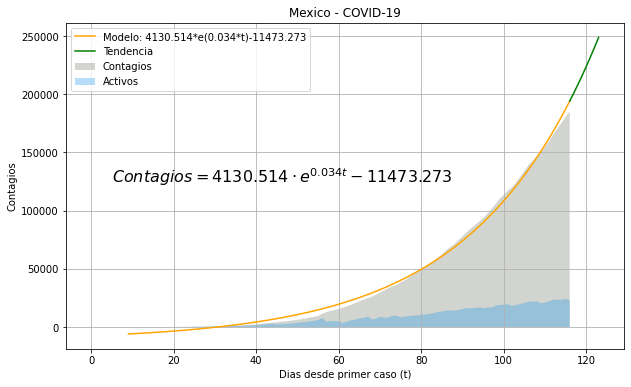

[194099. 201141. 208425. 215958. 223750. 231808. 240142. 248762.]

OBSERVACIONES:
De acuerdo a las acciones que tome el gobierno los datos se alejaran de la curva del modelo...
  - ACCIONES EFECTIVAS: Los datos se mueven a la derecha respecto al modelo
  - ACCIONES NO EFECTIVAS: Los datos siguen la tendencia o se mueven a la izquierda respecto al modelo


In [52]:
#@title
fecha_ini = "2020-03-07" #@param {type:"date"}
fecha_fin = "2020-06-22" #@param {type:"date"}
 
Activos = False #@param {type:"boolean"}
Exponencial = True #@param {type:"boolean"}
Grado_polinomio =  3#@param {type:"integer"}
dias_pred =  7#@param {type:"integer"}
Actualizar_BigQuery = False 
 
#dias_pred= 15
 
#TRAINNING & TEST 
cond_train,cond_test=dataset.loc[(dataset['date'] >= fecha_ini) & (dataset['date'] <= fecha_fin)],dataset.where(dataset["date"]>=fecha_fin).dropna()
#cond_train,cond_test = dataset.where(dataset["date"]<fecha_fin).dropna(),dataset.where(dataset["date"]>=fecha_fin).dropna()
 
campo = 5 if (Activos) else 2
x_train,y_train = cond_train.index.values.reshape(-1,1),cond_train.iloc[:, campo].values
x_test,y_test = cond_test.index.values.reshape(-1,1),cond_test.iloc[:, campo].values
 
#MODELO EXPONENCIAL 
if (Exponencial):
  y_pred,tend,coef=exponential_regression(x_train, y_train,dias_pred)
else:
  #MODELO POLINOMIO GRADO N
  from sklearn import linear_model
  from sklearn.preprocessing import PolynomialFeatures
  polinomio = PolynomialFeatures(degree = Grado_polinomio)
  x_modelo = polinomio.fit_transform(x_train)
 
  #MODELO
  modelo = linear_model.LinearRegression()
  modelo.fit(x_modelo,y_train)
  y_modelo = modelo.predict(x_modelo)
 
  #TEST MODELO
  from datetime import date
  today = date.today()
  dif_y,y_pred_test,prediccion_semana = [],[],[]
  fecha_hoy = format(today.year)+"-"+format(today.month).zfill(2)+"-"+format(today.day).zfill(2)
  if fecha_fin<fecha_hoy:
    y_pred_test = modelo.predict(polinomio.fit_transform(x_test))
    dif_y = pd.DataFrame(np.round(y_pred_test, decimals=0),y_test)
  #print(dif_y)
 
  #METRICAS
  from sklearn.metrics import mean_squared_error
  print("R²(modelo): "+str(round(modelo.score(x_modelo,y_train),4)))
  print("MSE: "+str(round(math.sqrt(mean_squared_error(y_pred_test, y_test)),4)))
  print('COEFICIENTES MODELO: '+ str(modelo.coef_) + "\n")
 
  #TENDENCIA 
  x_semana = np.array(dias_predecir(dias_pred+1))
  prediccion_semana = modelo.predict(polinomio.fit_transform(x_semana.reshape(-1,1)))
  print("PRONOSTICO DE {} DÍAS: {}".format(dias_pred,np.round(prediccion_semana,decimals=0)) )
  
  #GRAFICA
  plt.figure(figsize=[10,6])
  plt.title(pais + " - COVID-19")
  plt.xlabel('Dias desde primer caso')
  plt.ylabel('Contagios')
  plt.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
  plt.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
  plt.plot(x_train,y_modelo, color = "orange", label = "Modelo")
  plt.plot(x_test,y_pred_test, color = "green")
  plt.plot(x_semana,prediccion_semana, color = "green", label = "Pronóstico")
  plt.grid()
  plt.legend(loc='upper left')
 
if Activos==False:
  print("""\nOBSERVACIONES:\nDe acuerdo a las acciones que tome el gobierno los datos se alejaran de la curva del modelo...
  - ACCIONES EFECTIVAS: Los datos se mueven a la derecha respecto al modelo
  - ACCIONES NO EFECTIVAS: Los datos siguen la tendencia o se mueven a la izquierda respecto al modelo""")
 
#ACTUALIZAR DATOS BIG QUERY
if (Actualizar_BigQuery) and (Exponencial):
  columnas = ["fecha","pais","confirmados","muertes","recuperados",
              "activos","velocidad","aceleracion","indice_crecimiento","modelo"]
  dfs = [dataset,pd.DataFrame(velocidad),
                pd.DataFrame(aceleracion),
                pd.DataFrame(indice_crecimiento),
                pd.DataFrame(y_pred),
                ]
  df_todo=pd.concat(dfs,axis=1)
  df_todo.columns=columnas
  tendencia=pd.DataFrame(tend[1:])
  tendencia.columns=["modelo"]
  df_todo=df_todo.append(tendencia)
  df_todo=df_todo.reset_index()
  df_todo["dias"] = df_todo.index.values
  tabla = 'dataset.covid19_gt'
  df_todo.to_gbq(tabla,project_id=project_id,if_exists='replace')
 
  #COEFICIENTES
  coeficientes = pd.DataFrame(np.round(coef,decimals=3))
  coeficientes.columns=["coeficientes"]
  coeficientes["index"] = coeficientes.index.values
  tabla_coef = 'dataset.coef_funcion'
  coeficientes.to_gbq(tabla_coef,project_id=project_id,if_exists='replace')
 
elif (Actualizar_BigQuery):
  print("WARNING: Solo se puede actuliza datos del modelo Exponencial")

# **MODELO SIR**

HABITANTES:16,000,000 || R0=2.400 
POBLACION EXPUESTA(70.0%):11,200,000 || R0=2.000


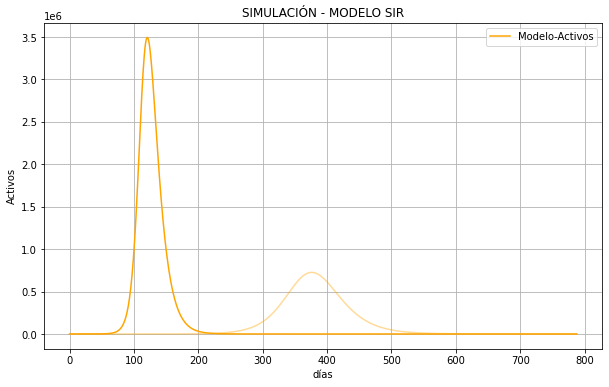

In [37]:
#@title
Poblacion =  16e6#@param {type:"number"}
beta =  0.24#@param {type:"number"}
gamma =  0.1#@param {type:"number"}
tiempo = 788 #@param {type:"slider", min:50, max:1000, step:1}
Exposicion = 0.7 #@param {type:"slider", min:0.1, max:1, step:0.1}
beta_test =  0.2#@param {type:"number"}
modelo_completo = False #@param {type:"boolean"}
datos_pais = False #@param {type:"boolean"}
Solo_Suceptibles = False #@param {type:"boolean"}
 
N=Poblacion
poblacion_expuesta=N/Exposicion
 
#VALORES INICIALES
I0,R0 = 1,0
S0 = N - I0 - R0
Ro = (beta)/(gamma)
Ro_test=(beta_test)/(gamma)
print('HABITANTES:{:,.0f} || R0={:.3f} \nPOBLACION EXPUESTA({}%):{:,.0f} || R0={:.3f}'.format(N,Ro,Exposicion*100,N*Exposicion,Ro_test))
 
#GRAFICA
plt.figure(figsize=[10,6])
 
if (modelo_completo) and Solo_Suceptibles==False:
  t = np.linspace(0,tiempo ,tiempo)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta, gamma))
  plt.ylabel("% Población")
  plt.plot(t, sol_ecuaciones[:, 1]/N, label="Activos", color="Orange")
  plt.plot(t, sol_ecuaciones[:, 0]/N, label="Suceptibles", color="Blue")
  plt.plot(t, sol_ecuaciones[:, 2]/N, label="Recuperados", color="Green")
  if Exposicion<1:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(poblacion_expuesta,beta_test, gamma))
    plt.ylabel("% Población")
    plt.plot(t, sol_ecuaciones2[:, 1]/N, color="Orange", alpha=0.4)
    plt.plot(t, sol_ecuaciones2[:, 0]/N, color="Blue", alpha=0.4)
    plt.plot(t, sol_ecuaciones2[:, 2]/N, color="Green", alpha=0.4) 
  else:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta_test, gamma))
    plt.ylabel("% Población")
    plt.plot(t, sol_ecuaciones2[:, 1]/N, color="Orange", alpha=0.4)
    plt.plot(t, sol_ecuaciones2[:, 0]/N, color="Blue", alpha=0.4)
    plt.plot(t, sol_ecuaciones2[:, 2]/N, color="Green", alpha=0.4) 
 
elif Solo_Suceptibles==False:
  t = np.linspace(0,tiempo ,tiempo)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta, gamma))
  plt.plot(t, sol_ecuaciones[:, 1], label="Modelo-Activos", color="Orange") 
  plt.ylabel("Activos")
  if Exposicion<1:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(poblacion_expuesta,beta_test, gamma)) 
    plt.plot(t, sol_ecuaciones2[:, 1], color="Orange", alpha=0.4) 
  else:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta_test, gamma)) 
    plt.plot(t, sol_ecuaciones2[:, 1], color="Orange", alpha=0.4) 
  if (datos_pais):
    plt.bar(x[0:tiempo+1].flatten(),activos[0:tiempo+1].flatten(), color="Blue",alpha=0.3,label="Suceptibles" )
 
if (Solo_Suceptibles):
  plt.ylabel("% Población")
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta, gamma) )
  plt.plot(t, sol_ecuaciones[:, 0]/N, label="Suceptibles", color="Blue")
  if Exposicion<1:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(poblacion_expuesta,beta_test, gamma) )
    plt.plot(t, sol_ecuaciones2[:, 0]/N, color="Blue", alpha=0.4)
  else:
    sol_ecuaciones2 = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta_test, gamma) )
    plt.plot(t, sol_ecuaciones2[:, 0]/N, color="Blue", alpha=0.4)
 
 
plt.title("SIMULACIÓN - MODELO SIR")
plt.xlabel("días")
plt.grid()
plt.legend()
plt.show()

# **MODELO SEIR**

R0 =1.515 
HABITANTES:100


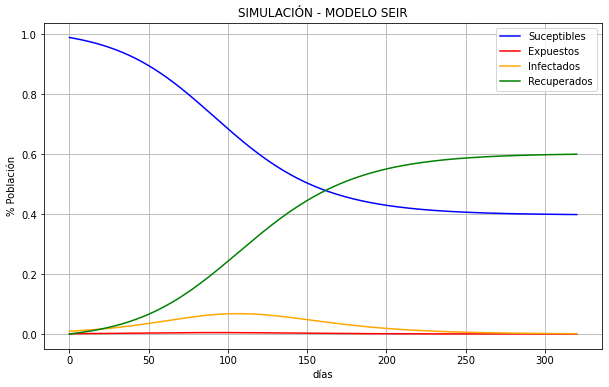

In [36]:
#@title
Poblacion =  100#@param {type:"number"}
beta =  0.1#@param {type:"number"}
gamma =  0.066#@param {type:"number"}
epsilon =  1#@param {type:"number"}
tiempo2 = 320 #@param {type:"slider", min:50, max:1000, step:1}
modelo_completo = True #@param {type:"boolean"}
N=Poblacion
 
#VALORES INICIALES
I0,R0,E0 = 1,0,0
S0 = N - I0 - R0 - E0
Ro = (beta)/(gamma)
B,mu=0,0.02
print('R0 ={:.3f} \nHABITANTES:{:,.0f}'.format(Ro,N) )
 
 
#GRAFICA
plt.figure(figsize=[10,6])
 
if (modelo_completo):
  t = np.linspace(0,tiempo2 ,tiempo2)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SEIR, [S0, E0, I0, R0], t, args=(N,beta,gamma,epsilon,mu,B) )
  plt.ylabel("% Población")
  plt.plot(t, sol_ecuaciones[:, 0]/N, label="Suceptibles", color="Blue")
  plt.plot(t, sol_ecuaciones[:, 1]/N, label="Expuestos", color="Red")
  plt.plot(t, sol_ecuaciones[:, 2]/N, label="Infectados", color="Orange")
  plt.plot(t, sol_ecuaciones[:, 3]/N, label="Recuperados", color="Green")
plt.title("SIMULACIÓN - MODELO SEIR")
plt.xlabel("días")
plt.grid()
plt.legend()
plt.show()

R0 =5.714 
HABITANTES:16,000,000


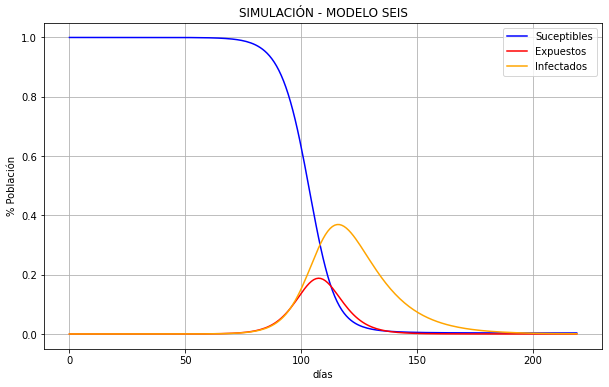

In [34]:
def Modelo_SEIS(y,t,N,beta, gamma,epsilon,mu,B):
  S, E, I = y
  dS = (-beta*S*I + gamma*I)/N
  dE = (beta*S*I)/N - epsilon*E
  dI = epsilon*E - gamma*I 
  return ([dS, dE, dI])



Poblacion =  16e6#@param {type:"number"}
beta =  0.4#@param {type:"number"}
gamma =  0.07#@param {type:"number"}
epsilon =  0.2#@param {type:"number"}
tiempo2 = 219 #@param {type:"slider", min:50, max:1000, step:1}
modelo_completo = True #@param {type:"boolean"}
N=Poblacion
 
#VALORES INICIALES
I0,R0,E0 = 1,0,0
S0 = N - I0 - R0 - E0
Ro = (beta)/(gamma)
B,mu=0,0.02
print('R0 ={:.3f} \nHABITANTES:{:,.0f}'.format(Ro,N) )
 
 
#GRAFICA
plt.figure(figsize=[10,6])
 
if (modelo_completo):
  t = np.linspace(0,tiempo2 ,tiempo2)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SEIS, [S0, E0, I0], t, args=(N,beta,gamma,epsilon,mu,B) )
  plt.ylabel("% Población")
  plt.plot(t, sol_ecuaciones[:, 0]/N, label="Suceptibles", color="Blue")
  plt.plot(t, sol_ecuaciones[:, 1]/N, label="Expuestos", color="Red")
  plt.plot(t, sol_ecuaciones[:, 2]/N, label="Infectados", color="Orange")
plt.title("SIMULACIÓN - MODELO SEIS")
plt.xlabel("días")
plt.grid()
plt.legend()
plt.show()

# **REFERENCIAS**
https://es.wikipedia.org/wiki/Modelaje_matem%C3%A1tico_de_epidemias

https://ajph.aphapublications.org/doi/pdf/10.2105/AJPH.2013.301704s

https://institucional.us.es/blogimus/2020/03/covid-19-analisis-por-medio-de-un-modelo-seir/
